In [8]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import langevin
import lmfit as lm
from lmfit.models import ExponentialModel

In [2]:
A,D = 1.0,1.0
delta_t=0.01
M=1000 # number of data sets
N=10000 # length of data set
P=500 # range to fit acf

In [3]:
# let us first calculate the standard deviation for each point of the acf
# all acfs are stored in acf_all for later analysis

acf_all = None
data_results_array = None

for i in range(M):
    data = langevin.time_series(A=A, D=D, delta_t=delta_t, N=N)

    data_results = [data[0]**2, data[-1]**2, np.sum(data[1:-2]**2), np.sum(data[:-1]*data[1:])]

    # calculate autocorrelation function
    f = np.fft.rfft(data)
    acf = np.fft.irfft(f * np.conjugate(f))
    acf = np.fft.fftshift(acf) / N
    autocorr = acf[int(N / 2):]

    y = autocorr[:min(int(N / 2), P)]
    t = np.arange(min(int(N / 2), P))

    if acf_all is None:
        acf_all = y
        data_results_array = data_results
    else:
        acf_all = np.vstack((acf_all, y))
        data_results_array = np.vstack((data_results_array, data_results))

acf_std = np.std(acf_all, axis=0)
acf_mean = np.mean(acf_all, axis=0)

***** Iteration  0  *****
***** Iteration  1  *****
***** Iteration  2  *****
***** Iteration  3  *****
***** Iteration  4  *****
***** Iteration  5  *****
***** Iteration  6  *****
***** Iteration  7  *****
***** Iteration  8  *****
***** Iteration  9  *****
***** Iteration  10  *****
***** Iteration  11  *****
***** Iteration  12  *****
***** Iteration  13  *****
***** Iteration  14  *****
***** Iteration  15  *****
***** Iteration  16  *****
***** Iteration  17  *****
***** Iteration  18  *****
***** Iteration  19  *****
***** Iteration  20  *****
***** Iteration  21  *****
***** Iteration  22  *****
***** Iteration  23  *****
***** Iteration  24  *****
***** Iteration  25  *****
***** Iteration  26  *****
***** Iteration  27  *****
***** Iteration  28  *****
***** Iteration  29  *****
***** Iteration  30  *****
***** Iteration  31  *****
***** Iteration  32  *****
***** Iteration  33  *****
***** Iteration  34  *****
***** Iteration  35  *****
***** Iteration  36  *****
***** Itera

<Container object of 3 artists>

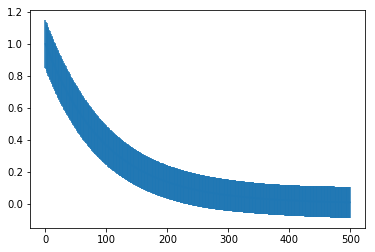

In [9]:
plt.errorbar(t,acf_mean,yerr=acf_std)

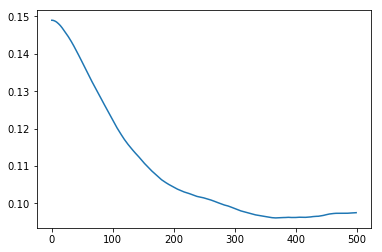

In [10]:
plt.plot(t,acf_std)

In [11]:
acf_all[0].size

500

In [13]:
result_array = None
for y in acf_all:
    print("***** Iteration ",i," *****")
    mod = ExponentialModel()
    pars = mod.guess(y, x=t)
    try:
        out = mod.fit(y, pars, x=t)
    except:
        fit_results = np.zeros(4)
        print('fit did not work')
    else:
        fit_results = np.array([out.values['decay']*delta_t,
                            np.sqrt(out.covar[0,0])*delta_t,
                            out.values['amplitude'],
                            np.sqrt(out.covar[1,1])])
        print(out.fit_report(min_correl=0.25))
        
    try:
        out2 = mod.fit(y, pars, x=t, weights=1/acf_std)
    except:
        fit_std_results = np.zeros(4)
        print('fit did not work')
    else:
        fit_std_results = np.array([out2.values['decay']*delta_t,
                            np.sqrt(out2.covar[0,0])*delta_t,
                            out2.values['amplitude'],
                            np.sqrt(out2.covar[1,1])])
        print(out2.fit_report(min_correl=0.25))

    results = np.concatenate((fit_results, fit_std_results))

    if result_array is None:
        result_array = results
    else:
        result_array = np.vstack((result_array, results))


***** Iteration  999  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 25
    # data points      = 500
    # variables        = 2
    chi-square         = 1.284
    reduced chi-square = 0.003
    Akaike info crit   = -2976.423
    Bayesian info crit = -2967.994
[[Variables]]
    amplitude:   1.01228832 +/- 0.011203 (1.11%) (init= 0.2745539)
    decay:       80.1645712 +/- 1.262555 (1.57%) (init= 163.0222)
[[Correlations]] (unreported correlations are <  0.250)
    C(amplitude, decay)          = -0.703 

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 25
    # data points      = 500
    # variables        = 2
    chi-square         = 132.814
    reduced chi-square = 0.267
    Akaike info crit   = -656.826
    Bayesian info crit = -648.397
[[Variables]]
    amplitude:   1.02162582 +/- 0.016144 (1.58%) (init= 0.2745539)
    decay:       78.8198415 +/- 1.517148 (1.92%) (init= 163.0222)
[[Correlations]] (unreported correlations 

(array([ 338.,  372.,  176.,   63.,   30.,    7.,    9.,    3.,    1.,    1.]),
 array([ 0.4120842 ,  0.82107181,  1.23005942,  1.63904703,  2.04803465,
         2.45702226,  2.86600987,  3.27499748,  3.68398509,  4.0929727 ,
         4.50196031]),
 <a list of 10 Patch objects>)

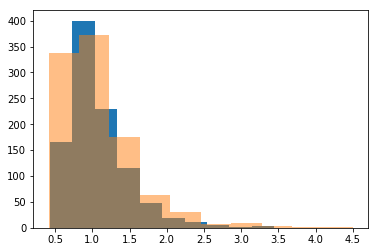

In [17]:
plt.hist(result_array.T[0])
plt.hist(result_array.T[4],alpha=0.5)

(array([   5.,   41.,  101.,  210.,  254.,  191.,  130.,   43.,   20.,    5.]),
 array([ 0.4256612 ,  0.54824379,  0.67082638,  0.79340896,  0.91599155,
         1.03857414,  1.16115673,  1.28373931,  1.4063219 ,  1.52890449,
         1.65148707]),
 <a list of 10 Patch objects>)

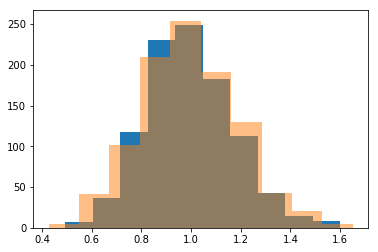

In [18]:
plt.hist(result_array.T[2])
plt.hist(result_array.T[6],alpha=0.5)